In [1]:
%load_ext autoreload
%autoreload 2

import datetime
import numpy as np
import scipy as sp
import pandas as pd
import functools as fts
import multiprocessing as mp
from tqdm.notebook import tqdm
from tqdm.contrib import tzip, tenumerate, tmap

from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
from pyspark.storagelevel import StorageLevel
from pyspark.sql.functions import col
import pyspark.sql.types as pstype
import pyspark.sql.functions as F
import pyspark as ps

import matplotlib as mlt
import matplotlib.pyplot as plt
from matplotlib.animation import ArtistAnimation
from IPython.display import HTML
import japanize_matplotlib

from time_series_model import *
from create_time_series import *

%matplotlib inline
%matplotlib ipympl

In [2]:
SPECIFIED_PATH = "csv_data/"
SPECIFIED_DATE = "20240918"
SPECIFIED_CSV  = SPECIFIED_PATH + SPECIFIED_DATE

In [3]:
data_num   = 5000
δ1         = 2
δ2         = 1
Σ          = 100 ** 2
regression = "ctt"
if   regression == "n":
    x_data = create_time_data_n(  data_num, Σ)

elif regression == "c":
    x_data = create_time_data_c(  data_num, Σ, np.random.normal(0, Σ))

elif regression == "ct":
    x_data = create_time_data_ct( data_num, Σ, np.random.normal(0, Σ), δ1)

elif regression == "ctt":
    x_data = create_time_data_ctt(data_num, Σ, np.random.normal(0, Σ), δ1, δ2)
else:
    raise

pd_data = pd.DataFrame({"x_data": x_data})
pd_data.to_csv(SPECIFIED_CSV + "_urp_data.csv", header=True, index=False)
pd_data

,x_data
0,2.092960e+03
1,-2.340669e+03
2,-6.673434e+03
3,-5.762856e+03
4,-1.338952e+04
...,...
4995,1.246269e+07
4996,1.246828e+07
4997,1.245846e+07
4998,1.245440e+07


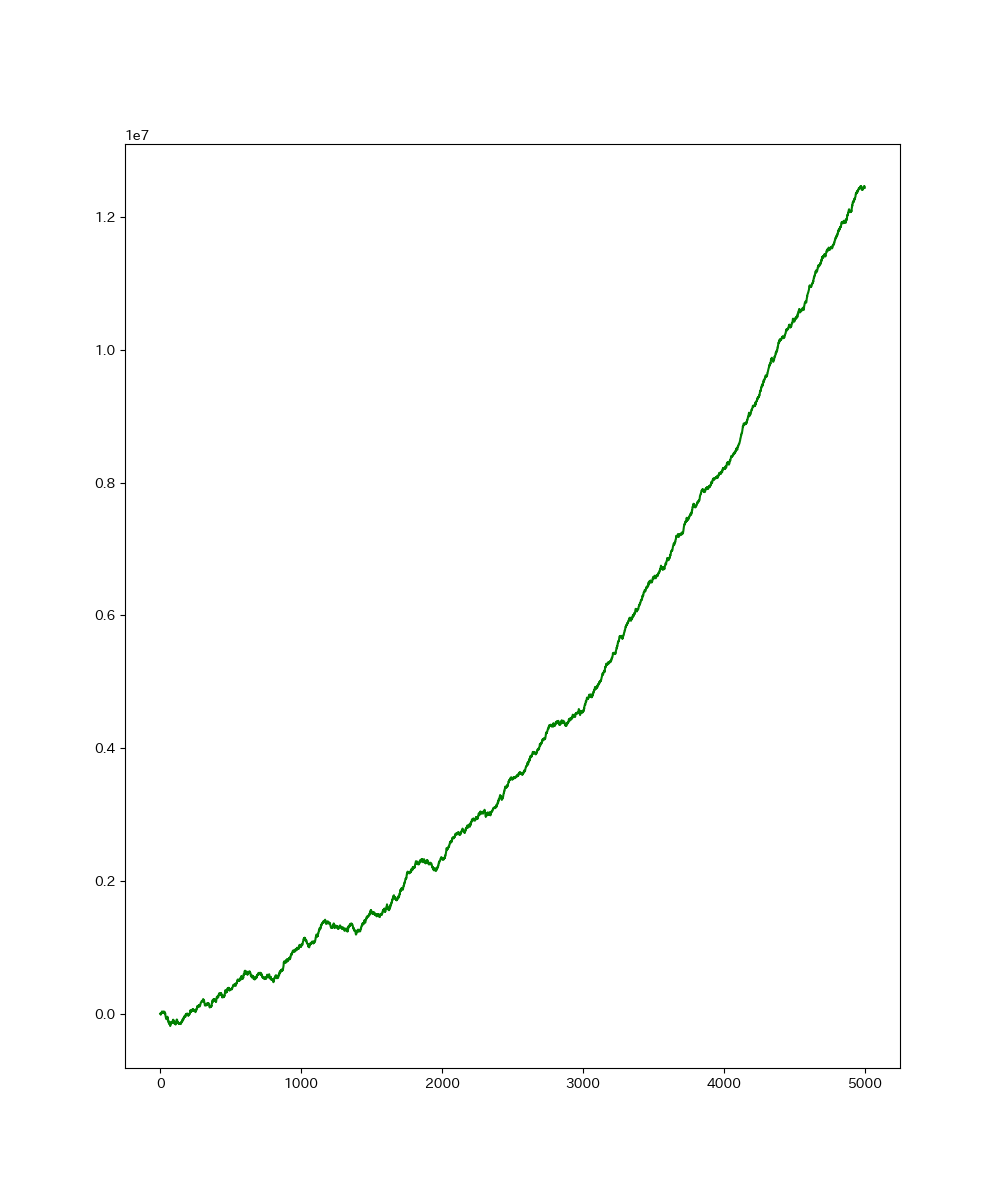

In [4]:
plt.figure(figsize=(10, 12))
plt.plot(x_data, "-", color="green")

In [5]:
from statsmodels.tsa.stattools import adfuller

# regression：データ構造により以下から指定
# n  ・・・定数項なし&トレンドなし
# c  ・・・定数項あり&トレンドなし
# ct ・・・定数項あり&1次のトレンドあり
# ctt・・・定数項あり&1次のトレンドあり&2次のトレンドあり
result = adfuller(pd_data.to_numpy(), autolag="BIC", regression="ctt")

print("ADF Statistic: %f" % result[0])
print("p-value: %f" % result[1])
print("used lag: %d" % result[2])
print("data num: %d" % result[3])
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
print("ic best: %f" % result[5])
print("ADF検定(有意水準5%)：", True if result[1] < 0.05 else False)

ADF Statistic: -2.492960
p-value: 0.573385
used lag: 0
data num: 4999
	1%: -4.373
	5%: -3.834
	10%: -3.554
ic best: 105578.920356
ADF検定(有意水準5%)： False


In [10]:
lags       = 5
data_num   = 5000
const      = 500
δ1         = 1
δ2         = 1
Σ          = 1000 ** 2
#coef       = np.random.rand(lags)
coef       = np.random.normal(0, Σ, lags)
coef       = coef / coef.sum()
regression = "ctt"
if   regression == "n":
    x_data = create_time_data_n_lag(  lags, data_num, coef, Σ)

elif regression == "c":
    x_data = create_time_data_c_lag(  lags, data_num, coef, Σ, const)

elif regression == "ct":
    x_data = create_time_data_ct_lag( lags, data_num, coef, Σ, const, δ1)

elif regression == "ctt":
    x_data = create_time_data_ctt_lag(lags, data_num, coef, Σ, const, δ1, δ2)
else:
    raise

pd_data = pd.DataFrame({"x_data": x_data})
pd_data.to_csv(SPECIFIED_CSV + "_urp_data_lags.csv", header=True, index=False)
pd_data

,x_data
0,5.000000e+02
1,1.436774e+06
2,1.408681e+06
3,1.109761e+06
4,4.067118e+05
...,...
4995,7.013399e+06
4996,5.547354e+06
4997,7.591711e+06
4998,6.852316e+06


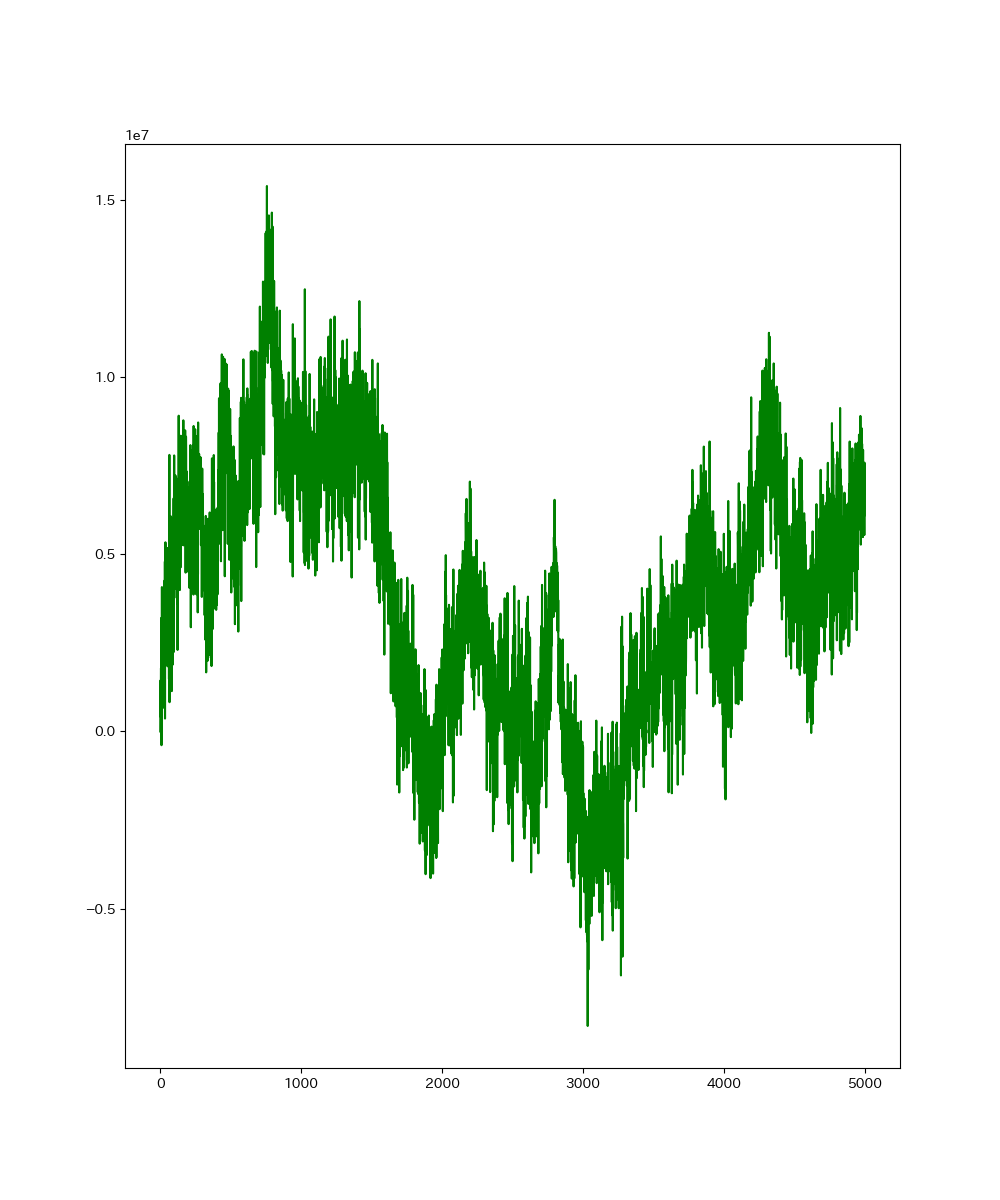

In [11]:
plt.figure(figsize=(10, 12))
plt.plot(x_data, "-", color="green")

In [12]:
from statsmodels.tsa.stattools import adfuller

# regression：データ構造により以下から指定
# n  ・・・定数項なし&トレンドなし
# c  ・・・定数項あり&トレンドなし
# ct ・・・定数項あり&1次のトレンドあり
# ctt・・・定数項あり&1次のトレンドあり&2次のトレンドあり
result = adfuller(pd_data.to_numpy(), autolag="BIC", regression="ctt")

print("ADF Statistic: %f" % result[0])
print("p-value: %f" % result[1])
print("used lag: %d" % result[2])
print("data num: %d" % result[3])
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
print("ic best: %f" % result[5])
print("ADF検定(有意水準5%)：", True if result[1] < 0.05 else False)

ADF Statistic: -3.800845
p-value: 0.054367
used lag: 4
data num: 4995
	1%: -4.373
	5%: -3.834
	10%: -3.554
ic best: 151399.689194
ADF検定(有意水準5%)： False
